In [1]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

import ellipses as el
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial import ConvexHull

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
from matplotlib.pyplot import figure
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()


In [2]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [3]:
#Conversion routines - cartesian to polar and vice versa
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [4]:
#How do we normalize the data? Can do either a moving window of 12 months on either side or a true calendar
#year. Select the highest value in either of these windows, then divide the timeseries by this value.
#meanNormalize does this for the sum of all patches, Normalize does it for each patch individually.
def meanNormalize(data):
    fold = 24
    nobs = len(data)
    dates = np.linspace(0,nobs-1,nobs) 
    dates = (dates)%fold     #A year is 24 timesteps, in this code. For whatever reason.
    nyear = sum(dates==fold-1)
    theta = 2.*np.pi*((dates)/float(fold-1))
    npatch = np.shape(data)[1]  
    thresh = int(npatch/100.)
    thresh = 0.
    data_summed = np.sum(data,axis=1)
    data_summed[data_summed<=thresh] = 0.
    data_summed = data_summed/float(npatch)
    data_norm = np.zeros([nobs]) 
    '''
    nhigh = 0
    for i in range(nyear):
        nhigh = np.max(data_summed[i*24:(i+1)*24])
        if nhigh ==0.:
            nhigh = 1.
        data_norm[i*24:(i+1)*24] = data_summed[i*24:(i+1)*24]/float(nhigh)   
    '''
    
    nhigh = 0 
    k = 0
    for d in dates:
        #This loop looks forward/backward 12 timesteps and finds the maximum in that window.
        if k<fold/2:
            nhigh = np.max(data_summed[0:k+fold/2])
        elif k>nobs-fold/2:
            nhigh = np.max(data_summed[k-fold/2:])
        else:
            nhigh = np.max(data_summed[k-fold/2:k+fold/2])    
        if nhigh==0.:
            nhigh += 1.5      #Don't divide by zero.
        data_norm[k] = data_summed[k]/float(nhigh)
        if nhigh==1.:   #Only one infection in this window - i.e. probably just a virgin intro. burst
            data_norm[k] = 0.
        k += 1
    
    return data_norm

def Normalize(data):
    nobs = len(data)      #How many 'observations'? (i.e. timesteps)
    dates = np.linspace(0,nobs-1,nobs) 
    dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
    nyear = sum(dates==23)
    theta = 2.*np.pi*((dates)/23.)
    npatch = np.shape(data)[1]  
    data_norm = np.zeros([nobs,npatch])
    #Looks over the calendar year:
    for p in range(npatch):
        nhigh = 0
        for i in range(nyear):
            nhigh = np.max(data[i*24:(i+1)*24,p])
            if nhigh ==0.:
                nhigh = 1.
            data_norm[i*24:(i+1)*24,p] = data[i*24:(i+1)*24,p]/float(nhigh)       
        
    '''
    k = 0
    for d in dates:
        #This loop looks forward/backward 12 timesteps and finds the maximum in that window.
        if k<12:
            nhigh = np.max(data[0:k+12,p])
        elif k>nobs-12:
            nhigh = np.max(data[k-12:,p])
        else:
            nhigh = np.max(data[k-12:k+12,p])    
        if nhigh==0.:
            nhigh += 1.5      #Don't divide by zero.
        data_norm[k,p] = data[k,p]/float(nhigh)
        if nhigh==1.:   #Only one infection in this window - i.e. probably just a virgin intro. burst
            data_norm[k,p] = 0.
        k += 1
        '''
    return data_norm

#Calculate the area of a convex hull around all of the data points.
def AreaCalc(data,theta,tstart=0):
    npatch = np.shape(data)[1] 
    area = []
    for i in range(npatch):
        thetafit = theta[tstart:]
        Ifit = data[tstart:,i]
        cartcoords = pol2cart(Ifit,thetafit)
        points = np.array(cartcoords)
        points = points.T
        if len(data)>1 and np.sum(data)>0.:
            hull = ConvexHull(points)
            area.append(hull.volume)
        if np.sum(data)==0.:
            area.append(np.pi)
    return area

In [29]:
#Likelihood functions for fitting ellipse and gaussian
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def eLike(p,t,d):
    fac = 2.   #factor for penalizing outside the ellipse higher than inside.
    
    e = p[0]
    a = p[1]
    phi = p[2]

    recc = a*(1.-e*e)/(1.-e*np.cos(t-phi)) #radius of the ellipse at phi
    delta = (recc-d)
    delta[delta<0.] *= fac  #apply factor to points that are outside of ellipse
    dmask = d>0.
    
    if np.sum(d)==0.:
        p[0] = 0.   #If there are no cases, the eccentricity is zero.
        p[1] = 0.25

    return -np.sum(delta[dmask]**2)  #return the sum of the differences squared (chi-squared likelihood basically)

def gLike(p,d):
    meanx = p[0]
    meany = p[1]
    sigx = p[2]
    sigy = p[3]
    sigxy = p[4]
    
    comat = [[sigx,sigxy],[sigxy,sigy]]
    
    if ~is_pos_def(comat):
        return -np.inf
    
    liked = sp.stats.multivariate_normal.logpdf(d, mean=[meanx,meany], cov=comat)
    return np.sum(liked)


#Jump proposals for the MCMC. Very unsophisticated but they work just fine.
def bigstep(x):
    delta = np.random.normal(loc=0.,scale=0.5,size=np.shape(x))
    y = x + delta
    return y

def smallstep(x):
    delta = np.random.normal(loc=0.,scale=0.05,size=np.shape(x))
    y = x + delta
    return y

def tinystep(x):
    delta = np.random.normal(loc=0.,scale=0.005,size=np.shape(x))
    y = x + delta
    return y


def ebigstep(x):
    delta = np.random.normal(loc=0.,scale=0.5,size=np.shape(x))
    y = x + delta
    return y

def esmallstep(x):
    delta = np.random.normal(loc=0.,scale=0.05,size=np.shape(x))
    y = x + delta
    return y

def etinystep(x):
    delta = np.random.normal(loc=0.,scale=0.005,size=np.shape(x))
    y = x + delta
    return y
    

In [30]:
#Read in the data.
data_pd = pd.read_csv('cases_vacc_0.93_0.csv',\
                      delim_whitespace=True,header=0)

#Normalize it.
Idata = data_pd.values.copy()
Idata = Idata[:,:]
Idata_norm = np.zeros(shape=np.shape(Idata))
nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
dates = np.linspace(0,nobs-1,nobs) 
dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
theta = 2.*np.pi*((dates+1)/24.)

#print np.max(Idata)
#plt.plot(Idata);

(360, 400)
(360,)


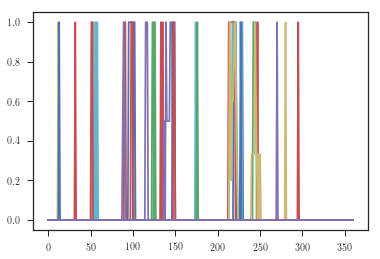

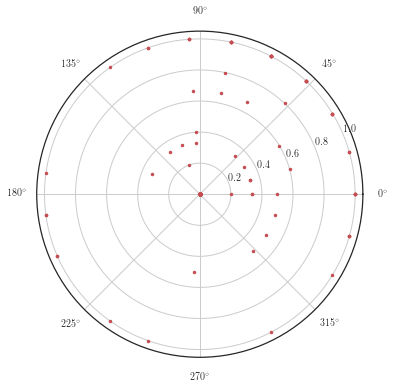

In [31]:
#Select the last n number of years
Idata_norm = Normalize(Idata[-15*24:,:])

plt.plot(Idata_norm[:]);
print np.shape(Idata_norm)

fold = 24
nobs = np.shape(Idata_norm[:])[0]
dates = np.linspace(0,nobs-1,nobs) 
dates = (dates)%fold     #Wrap the data every fold steps
angle = 2.*np.pi*((dates)/float(fold-1))

print np.shape(angle)

#x = Idata_norm[:]*np.cos(angle)
#y = Idata_norm[:]*np.sin(angle)
#print np.shape(x)

#plt.plot(x,y)
figure(figsize=(8,6))
plt.polar(angle[-10*24:-1],Idata_norm[-10*24:-1],'r.');
#plt.savefig('highvacc.png')


#Idata_norm = np.reshape(Idata_norm,[len(Idata_norm)])
#AreaCalc(Idata_norm,angle,tstart=0)


e: 0.0 a: 0.25 phi: 1.4632920213532548


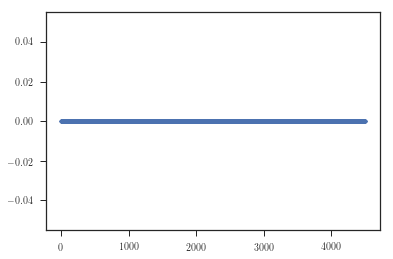

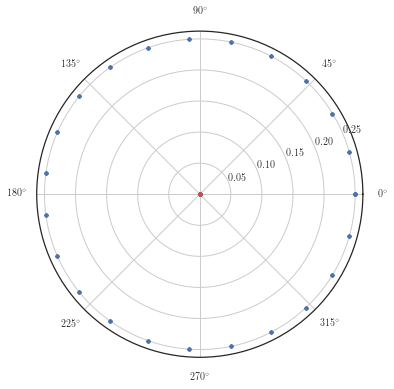

In [32]:
#MCMC fit of an ellipse to the data. More heavily penalize points that are outside elipse than points that are inside 
# it to avoid all of the zeroes biasing the result.
r = Idata_norm[-15*24:,2]
t = angle[-15*24:]

p0 = np.array([0.,0.5,0.])
like0 = eLike(p0,t,r)

params = p0.copy()
Nstep = 5000

chain = []
chain.append(p0)

Lchain = []
Lchain.append(like0)
for j in range(Nstep):
    s = np.random.rand(1)
    if s>0.75:
        ptry = ebigstep(params)
    elif s>0.5:
        ptry = etinystep(params)
    else:
        ptry = esmallstep(params)
        
    #enforce periodic prior on phi:
    if ptry[2]>np.pi:
        ptry[2] -= np.pi
    
    if ptry[2]<0.:
        ptry[2] += np.pi
    like_try = eLike(ptry,t,r)
    #eccentricity is between 0 and 1:
    if ptry[0] >1.:
        like_try = -np.inf
    if ptry[0] <0.:
        like_try = -np.inf
    
    H = np.random.rand(1)
    h = np.exp(like_try - like0)
    
    if H<h:
        params = ptry
        like0 = like_try
    
    chain.append(params)
    Lchain.append(like0)


chain = np.array(chain)
size = 100

e = np.mean(chain[500:,0])
a = np.mean(chain[500:,1])
phi = np.mean(chain[500:,2])
print 'e:',e,'a:',a,'phi:',phi

#I'm not sure what this is, actually. The area, maybe?
recc = a*(1.-e*e)/(1.-e*np.cos(t-phi))

plt.plot(chain[500:,0],'.')

figure(figsize=(8,6))

plt.polar(t,r,'r.')
plt.polar(t,recc,'b.')

#plt.savefig('highvacc_fit.png')


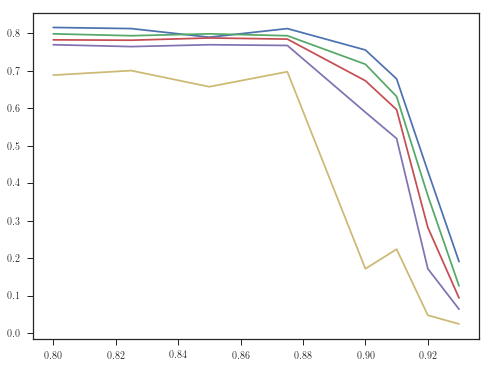

In [33]:
#Vaccination level, eccentricity for various values of the 'factor' that imposes
#a greater penalty for points outside the elipse than inside.
vlevels = np.array([0.8,0.825,0.85,0.875,0.9,0.91,0.92,0.93])
fac15 = np.array([0.798,0.793,0.798,0.793,0.717,0.631,0.367,0.126])
fac2 = np.array([0.782,0.781,0.787,0.784,0.673,0.596,0.282,0.094])
fac1 = np.array([0.815,0.812,0.789,0.812,0.755,0.678,0.432,0.191])
fac3 = np.array([0.769,0.764,0.769,0.767,0.589,0.519,0.172,0.064])
fac10 = np.array([0.688,0.7,0.657,0.697,0.1718,0.224,0.048,0.0247])

figure(figsize=(8,6))

plt.plot(vlevels,fac1)
plt.plot(vlevels,fac15)
plt.plot(vlevels,fac2)
plt.plot(vlevels,fac3)
plt.plot(vlevels,fac10)

plt.savefig('eccvsvacc.png')

-337.67193507243576
-0.00024429136927937763


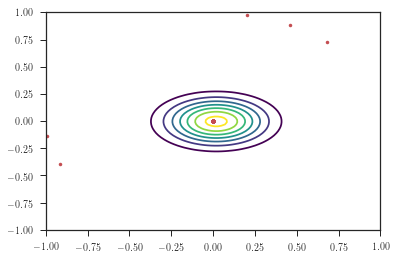

In [34]:
#This runs the Gaussian fit MCMC:    
#(as you can see by the plot at the bottom, the results are not encouraging.)
r = Idata_norm[-10*24:,0]
t = angle[-10*24:]

x = r*np.cos(t)
y = r*np.sin(t)

data = np.stack([x,y],axis=1)

param0 = np.array([0.,0.5,0.5,0.5,0.])
like0 = gLike(param0,data)
print like0

params = param0.copy()
Nstep = 100000

chain = []
chain.append(param0)

Lchain = []
Lchain.append(like0)
for j in range(Nstep):
    s = np.random.rand(1)
    if s>0.75:
        ptry = bigstep(params)
    elif s>0.5:
        ptry = tinystep(params)
    else:
        ptry = smallstep(params)
        
    like_try = gLike(ptry,data)
    
    H = np.random.rand(1)
    h = np.exp(like_try - like0)
    
    if H<h:
        params = ptry
        like0 = like_try
    
    chain.append(params)
    Lchain.append(like0)
    

chain = np.array(chain)
print np.mean(chain[500:,0])

size = 100
mean_x = 0.019
mean_y = -0.003
sigma_x = 0.038
sigma_y = 0.019
sigma_xy = 0.0


xplot = np.linspace(-1., 1., size)
yplot = np.linspace(-1., 1., size)

xplot, yplot = np.meshgrid(xplot, yplot)
z = (1/(2*np.pi*np.sqrt(sigma_x*sigma_y)) * np.exp(-((xplot-mean_x)**2/(2*sigma_x)
     + (yplot-mean_y)**2/(2*sigma_y))))

plt.contour(xplot,yplot,z,cmap='viridis')
plt.plot(x,y,'r.');

In [35]:
#This will draw a polar plot with the line changing as a function of time, but the output is confusing me.
'''angles = np.repeat(angle,400)
angles = angles.reshape([len(angle),400])
rad = Idata_norm[tstart:]
rad = testdata[0:24]

x = rad * np.sin(angle[0:24])
y = rad * np.cos(angle[0:24])

fig, axes = plt.subplots(figsize=(12,12))

colorline(x, y, cmap='coolwarm', linewidth=2) #, [0.3]*8+[0.4]*4+[0.5]*2)

plt.xlim(x.min() - 0.1, x.max() + 0.1)
plt.ylim(y.min() - 0.1, y.max() + 0.1)

plt.axis('equal')
#clear_frame()
'''

"angles = np.repeat(angle,400)\nangles = angles.reshape([len(angle),400])\nrad = Idata_norm[tstart:]\nrad = testdata[0:24]\n\nx = rad * np.sin(angle[0:24])\ny = rad * np.cos(angle[0:24])\n\nfig, axes = plt.subplots(figsize=(12,12))\n\ncolorline(x, y, cmap='coolwarm', linewidth=2) #, [0.3]*8+[0.4]*4+[0.5]*2)\n\nplt.xlim(x.min() - 0.1, x.max() + 0.1)\nplt.ylim(y.min() - 0.1, y.max() + 0.1)\n\nplt.axis('equal')\n#clear_frame()\n"

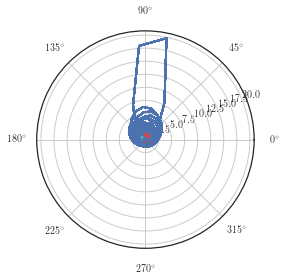

In [46]:
#Now what happens if you do this at the patch level?
Idata_norm = Normalize(Idata)
fold = 24
nobs = len(Idata_norm[:])
dates = np.linspace(0,nobs-1,nobs) 
dates = (dates)%fold     #Wrap the data every fold steps
angle = 2.*np.pi*((dates)/float(fold-1))



#select the nyear final years of data set
nyear = 15
t = angle[-nyear*24:]
npatch = np.shape(Idata)[1]
e = []
for p in range(400):
    r = Idata_norm[-nyear*24:,p]
    plt.plot(r)
    #starting point/likelihood for the train
    p0 = np.array([0.,0.5,0.])
    like0 = eLike(p0,t,r)

    params = p0.copy()
    Nstep = 5000  #number of steps for the MCMC

    chain = []
    chain.append(p0)

    Lchain = []
    Lchain.append(like0)
    for step in range(Nstep):
        s = np.random.rand(1)
        if s>0.75:
            ptry = ebigstep(params)
        elif s>0.5:
            ptry = etinystep(params)
        else:
            ptry = esmallstep(params)

        #enforce periodic prior on phi:
        if ptry[2]>np.pi:
            ptry[2] -= np.pi

        if ptry[2]<0.:
            ptry[2] += np.pi
        like_try = eLike(ptry,t,r)
        #eccentricity is between 0 and 1:
        if ptry[0] >1.:
            like_try = -np.inf
        if ptry[0] <0.:
            like_try = -np.inf

        #Hastings ratio
        H = np.random.rand(1)
        h = np.exp(like_try - like0)

        if H<h:
            params = ptry
            like0 = like_try

        chain.append(params)
        Lchain.append(like0)

    chain = np.array(chain)
    chain = np.array(chain)
    epatch = np.mean(chain[500:,0])
    
    eplot = np.mean(chain[500:,0])
    a = np.mean(chain[500:,1])
    phi = np.mean(chain[500:,2])
    recc = a*(1.-eplot*eplot)/(1.-eplot*np.cos(t-phi))

    plt.polar(t,r,'r.')
    plt.polar(t,recc,'b-')
    
    
    e.append(epatch)
    
    

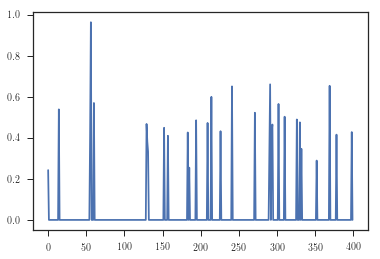

In [47]:
plt.plot(e)

In [49]:
e = np.array(e)
mask = e==0.
print np.mean(e[~mask])

0.47330294177841686


In [50]:
print np.mean(e)

0.0366809779878273
